#follow this to install prismnet
https://github.com/kuixu/PrismNet

In [1]:
import argparse, os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler



from sklearn import metrics
import numpy as np

import prismnet.model as arch
from prismnet import train, validate, inference, log_print, compute_saliency, compute_saliency_img, compute_high_attention_region
#compute_high_attention_region

# from prismnet.engine.train_loop import 
from prismnet.model.utils import GradualWarmupScheduler
from prismnet.loader import SeqicSHAPE
from prismnet.utils import datautils

In [2]:
# # out dir

# identity   = args.p_name+'_'+args.arch+"_"+args.mode # 441_PUM2_K562_sub4509_PrismNet_pu.metrics
# datautils.make_directory(args.out_dir,"out/")
# model_dir  = datautils.make_directory(args.out_dir,"out/models")
# model_path = os.path.join(model_dir, identity+"_{}.pth")

# if args.tfboard:
#     tfb_dir  = datautils.make_directory(args.out_dir,"out/tfb")
#     writer = SummaryWriter(tfb_dir)
# else:
#     writer = None
# # fix random seed
# fix_seed(args.seed)

In [3]:
import pandas as pd
outstem = 'K562_rep6'
outstem2 = 'K562_rep6.region_type'
rbp = 'IGF2BP2'
region = 'UTR3'
megaoutput = pd.read_csv(f'../data/ABC_data/{outstem}.megaoutputs_masked.tsv', sep = '\t')
seq = pd.read_csv(f'../data/ABC_data/tsv/{outstem}.DDX3.tsv', sep = '\t', names = ['chrom', 'name', 
                                                                                 'seq', 'struct', 'label', 'start'])

In [4]:
variants = pd.read_csv(f'../data/variants/{outstem}.{rbp}.chr22.csv')

In [5]:
max_length=seq['seq'].str.len().max()

In [6]:
variants = variants.loc[variants['variant_seq'].str.len()<=max_length]

In [7]:
# also score normal things
seq = seq.loc[seq['name'].isin(variants['name'])]

In [8]:
from prismnet.utils import datautils

In [9]:
one_hot_wt = datautils.convert_one_hot(seq['seq'], max_length)
one_hot_var = datautils.convert_one_hot(variants['variant_seq'], max_length)

In [10]:
# targets: predict binary
target_col = megaoutput.columns[(megaoutput.columns.str.startswith('logLR'))&(megaoutput.columns.str.contains(outstem))]
target_df = megaoutput.set_index('name').loc[seq['name'],target_col]
targets_wt = target_df.values


In [11]:
targets_var = variants.merge(target_df, left_on = 'name', right_index = True)[target_df.columns].values

In [12]:
one_hot_wt.shape, one_hot_var.shape, targets_wt.shape

((247, 4, 100), (4402, 4, 100), (247, 10))

In [13]:
from prismnet.model.PrismNet import *
class PrismNet_Multitask(nn.Module):
    def __init__(self, mode="pu", output_dim=10):
        super(PrismNet_Multitask, self).__init__()
        self.mode = mode
        h_p, h_k = 2, 5 
        if mode=="pu":
            self.n_features = 5
        elif mode=="seq":
            self.n_features = 4
            h_p, h_k = 1, 3 
        elif mode=="str":
            self.n_features = 1
            h_p, h_k = 0, 1
        else:
            raise "mode error"
        
        base_channel = 8
        self.conv    = Conv2d(1, base_channel, kernel_size=(11, h_k), bn = True, same_padding=True)
        self.se      = SEBlock(base_channel)
        self.res2d   = ResidualBlock2D(base_channel, kernel_size=(11, h_k), padding=(5, h_p)) 
        self.res1d   = ResidualBlock1D(base_channel*4) 
        self.avgpool = nn.AvgPool2d((1,self.n_features))
        self.gpool   = nn.AdaptiveAvgPool1d(1)
        self.fc      = nn.Linear(base_channel*4*8, output_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, input):
        """[forward]
        
        Args:
            input ([tensor],N,C,W,H): input features
        """
        if self.mode=="seq":
            input = input[:,:,:,:4]
        elif self.mode=="str":
            input = input[:,:,:,4:]
        x = self.conv(input)
        x = F.dropout(x, 0.1, training=self.training)
        z = self.se(x)
        x = self.res2d(x*z)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.avgpool(x)
        x = x.view(x.shape[0], x.shape[1], x.shape[2])
        x = self.res1d(x)
        x = F.dropout(x, 0.3, training=self.training)
        x = self.gpool(x)
        x = x.view(x.shape[0], x.shape[1])
        x = self.fc(x)
        return x


In [14]:
model = PrismNet_Multitask(mode = 'seq', output_dim = targets_wt.shape[1])
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)
model.load_state_dict(torch.load(f'../data/ABC_data/{outstem}.maskw.model.pt'))

<All keys matched successfully>

In [15]:
class SeqicSHAPE_Multitask(torch.utils.data.Dataset):
    def __init__(self, X, Y, is_infer=False, use_structure=True):
        """data loader
        
        Args:
            data_path ([str]): h5 file path
            is_test (bool, optional): testset or not. Defaults to False.
        """
        if is_infer:
            self.dataset = self.__load_infer_data__(data_path, use_structure=use_structure)
            print("infer data: ", self.__len__()," use_structure: ", use_structure)
        else:
#             dataset = h5py.File(data_path, 'r')
#             X_train = np.array(dataset['X_train']).astype(np.float32)
#             Y_train = np.array(dataset['Y_train']).astype(np.int32)
#             X_test  = np.array(dataset['X_test']).astype(np.float32)
#             Y_test  = np.array(dataset['Y_test']).astype(np.int32)
            X = np.array(X).astype(np.float32)
            Y = np.array(Y).astype(np.float32)
#             if len(Y_train.shape) == 1:
#                 Y_train = np.expand_dims(Y_train, axis=1)
#                 Y_test  = np.expand_dims(Y_test, axis=1)
            X = np.expand_dims(X, axis=3).transpose([0, 3, 2, 1]) # N, 1, length, channel
            

            

#             labels, nums = np.unique(Y_train,return_counts=True)
#             print("train:", labels, nums)
#             labels, nums = np.unique(Y_test,return_counts=True)
#             print("test:", labels, nums)

#             train = self.__prepare_data__(train)
#             test  = self.__prepare_data__(test)

            
            self.dataset = {'inputs': X, 'targets': Y}
            

        

    def __load_infer_data__(self, data_path, use_structure=True):
        from prismnet.utils import datautils
        dataset = datautils.load_testset_txt(data_path, use_structure=use_structure, seq_length=101)
        return dataset
       
    
    def __prepare_data__(self, data):
        inputs    = data['inputs'][:,:,:,:4]
        structure = data['inputs'][:,:,:,4:]
        structure = np.expand_dims(structure[:,:,:,0], axis=3)
        inputs    = np.concatenate([inputs, structure], axis=3)
        data['inputs']  = inputs
        return data

    def __to_sequence__(self, x):
        x1 = np.zeros_like(x[0,:,:1])
        for i in range(x1.shape[0]):
            # import pdb; pdb.set_trace()
            x1[i] = np.argmax(x[0,i,:4])
            # import pdb; pdb.set_trace()
        return x1

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        x = self.dataset['inputs'][index]
        # x = self.__to_sequence__(x)
        y = self.dataset['targets'][index]
        return x, y


    def __len__(self):
        return len(self.dataset['inputs'])



In [16]:
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
# train_loader = torch.utils.data.DataLoader(
    
    
#     SeqicSHAPE_Multitask(train[0], train[1], is_infer=False, use_structure=False), 
# batch_size=64, shuffle=True,  **kwargs)

test_loader  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(one_hot_wt, targets_wt, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)

test_loader_var  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(one_hot_var, targets_var, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)


print("Test  set:", len(test_loader.dataset))
print("Test  set:", len(test_loader_var.dataset))

Test  set: 247
Test  set: 4402


In [17]:
def train(model, device, train_loader, criterion, optimizer):
    ''' train for one epoch'''
    model.train()
    epoch_loss = 0
    for batch_idx, (x0, y0) in enumerate(train_loader):
        x, y = x0.float().to(device), y0.to(device).float()
        
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output, y)
        epoch_loss+=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

    return epoch_loss
def validate(model, device, test_loader, criterion):
    model.eval()
    y_all = []
    p_all = []
    l_all = []
    epoch_loss = 0
    with torch.no_grad():
        for batch_idx, (x0, y0) in enumerate(test_loader):
            x, y = x0.float().to(device), y0.to(device).float()
            
            
            output  = model(x)
            loss = criterion(output, y)
            
            epoch_loss += loss.item()
            y_np = output.to(device='cpu', dtype=torch.float32).numpy()
            y_all.append(y_np)
            
    y_pred=np.concatenate(y_all)
    return epoch_loss, y_pred

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-6)
nepoch = 60
scheduler = GradualWarmupScheduler(
    optimizer, multiplier=8, total_epoch=nepoch, after_scheduler=None)
criterion = torch.nn.MSELoss()
batch_size= 64

In [19]:
loss_test, y_pred = validate(model, device, test_loader, criterion)
loss_test_var, y_pred_var = validate(model, device, test_loader_var, criterion)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [20]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['pdf.fonttype'] = 42
def plot_pearson_correlation(y_pred, target_df, targets):
    f, axes = plt.subplots(2,5, figsize = (15,6))
    pearsondf = []

    for rbp_idx, name, ax in zip(range(y_pred.shape[1]), target_df.columns, axes.flatten()):
        ytest = targets[:, rbp_idx]
        yhat = y_pred[:, rbp_idx]
        
        min_val = min(ytest.min(), yhat.min())-1
        max_val = max(ytest.max(), yhat.max())+1
        
        ax.scatter(ytest, yhat, color = 'grey', marker = '+')
        rbp = name.split('.')[-1]
        ax.set_xlabel(f'logLR:{rbp}')
        ax.set_ylabel(f'PredictedlogLR:{rbp}')
        
        r,p=pearsonr(ytest,yhat)
        ax.set_title(f'pearson={r:.2f}')
        pearsondf.append([name, r, p])
    pearsondf = pd.DataFrame(pearsondf, columns = ['RBP', 'pearsonr', 'pvalue'])
    sns.despine()
    plt.tight_layout()
    return pearsondf


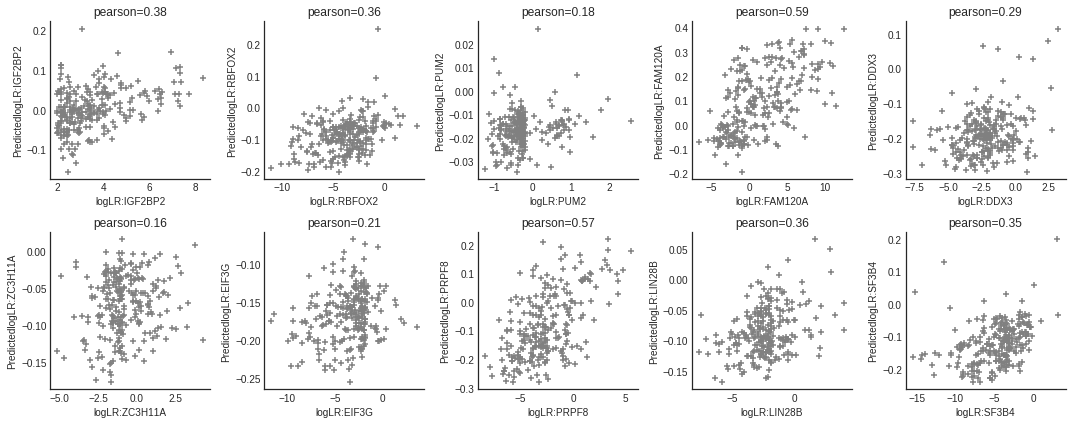

In [21]:
wt_pearson = plot_pearson_correlation(y_pred, target_df, targets_wt)

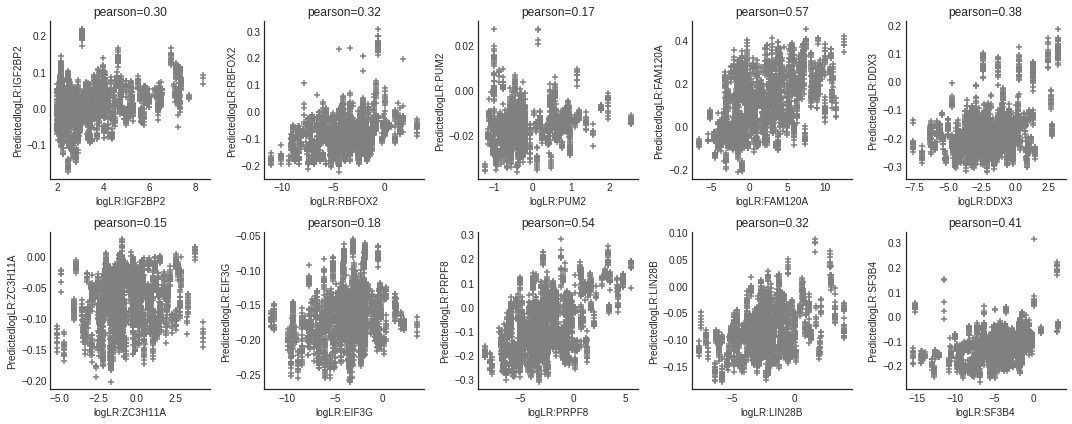

In [22]:
var_pearson = plot_pearson_correlation(y_pred_var, target_df, targets_var)

In [23]:
y_pred_var_df = pd.DataFrame(y_pred_var, index = variants.index, columns = target_df.columns)
y_pred_wt_df = pd.DataFrame(y_pred, index = seq['name'], columns = target_df.columns)

In [24]:
# map to variants dataframe
variants[f'variant_score_{rbp}'] = y_pred_var_df[f'logLR:{outstem}.{rbp}']
variants[f'wt_score_{rbp}'] = variants['name'].map(y_pred_wt_df[f'logLR:{outstem}.{rbp}'])

<AxesSubplot:ylabel='Frequency'>

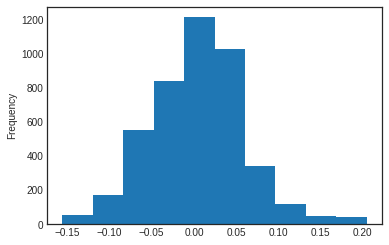

In [25]:
variants[f'wt_score_{rbp}'].plot.hist()

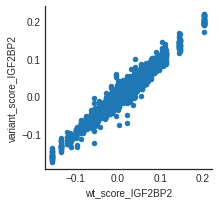

In [26]:
variants.plot.scatter(x = f'wt_score_{rbp}', y = f'variant_score_{rbp}', figsize = (3,3))
sns.despine()

In [27]:
variants['delta_score'] = (variants[f'variant_score_{rbp}']-variants[f'wt_score_{rbp}'])

<AxesSubplot:>

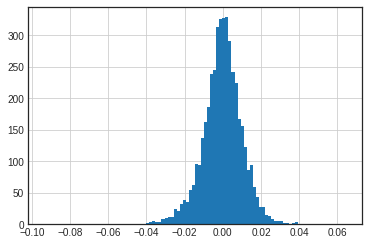

In [28]:
variants['delta_score'].hist(bins = 100)

In [29]:
variants['MAF']=(variants['INFO/AC']/variants['INFO/AN'])

In [30]:
variants = variants.loc[variants['INFO/AC']>0]
variants['MAF_bin']= pd.cut(variants['MAF'], bins = [0,0.001, 0.01, 1]).astype(str)
variants.loc[variants['INFO/AC']==1, 'MAF_bin']='singleton'
#variants.loc[variants['INFO/AC']==0, 'MAF_bin']='zero'



/tmp/ipykernel_2278/3908522242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants['MAF_bin']= pd.cut(variants['MAF'], bins = [0,0.001, 0.01, 1]).astype(str)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [31]:
variants['MAF_bin'].unique()

array(['(0.0, 0.001]', 'singleton', '(0.01, 1.0]', '(0.001, 0.01]'],
      dtype=object)

In [32]:
variants['MAF_bin'] = pd.Categorical(variants['MAF_bin'], categories=['singleton', '(0.0, 0.001]', '(0.001, 0.01]', '(0.01, 1.0]']
                                     , ordered=False)

/tmp/ipykernel_2278/2645864163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants['MAF_bin'] = pd.Categorical(variants['MAF_bin'], categories=['singleton', '(0.0, 0.001]', '(0.001, 0.01]', '(0.01, 1.0]']


<AxesSubplot:title={'center':'wt_score_IGF2BP2'}, xlabel='MAF_bin'>

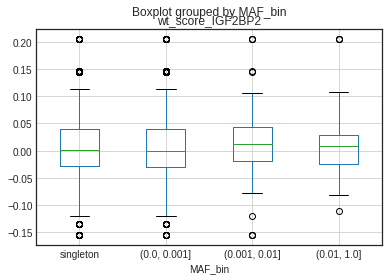

In [33]:
variants.boxplot(by = 'MAF_bin', column = f'wt_score_{rbp}')

<AxesSubplot:title={'center':'variant_score_IGF2BP2'}, xlabel='MAF_bin'>

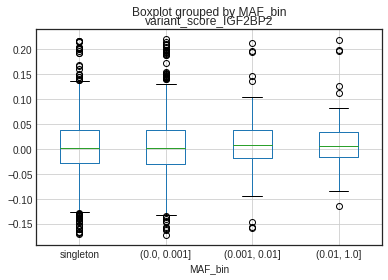

In [34]:
variants.boxplot(by = 'MAF_bin', column = f'variant_score_{rbp}')

<AxesSubplot:title={'center':'delta_score'}, xlabel='MAF_bin'>

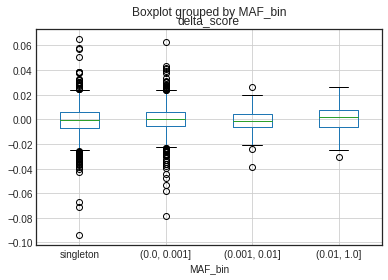

In [35]:
variants.boxplot(by = 'MAF_bin', column = 'delta_score')

In [36]:
import  statsmodels.api as sm


In [37]:
results = []
for name, group in variants.loc[variants['delta_score']<0].groupby(by = ['feature_type_top']):
    group['MAF_bin_rank'] = group['MAF_bin'].cat.codes
#     group.boxplot(by = 'MAF_bin', column = 'delta_score')
#     plt.title(name)
    mod = sm.OLS(group['delta_score'], group['MAF_bin_rank'])

    res = mod.fit()
    
    results.append([res.pvalues['MAF_bin_rank'], res.params['MAF_bin_rank'], name])
results = pd.DataFrame(results, columns = ['pvalue', 'coef', 'feature_type_top'])

In [38]:
from statsmodels.stats.multitest import fdrcorrection
results.dropna(subset = ['pvalue'], inplace = True)
_,results['FDR'] = fdrcorrection(results['pvalue'])
results.sort_values(by = 'FDR')

,pvalue,coef,feature_type_top,FDR
10,4.413912e-73,-0.006398,UTR3,5.296695e-72
0,6.505203e-13,-0.005482,CDS,3.903122e-12
5,6.832929e-07,-0.004832,INTRON,2.733172e-06
3,2.019489e-04,-0.006442,EXON_LNCRNA,6.058468e-04
2,8.094498e-04,-0.006057,CDS_STOP,1.942680e-03
8,3.420405e-03,-0.002480,SS5_PROX,6.840810e-03
11,5.743792e-03,-0.002039,UTR5,9.846500e-03
9,1.351866e-02,-0.009108,SSB_PROX,2.027798e-02
1,2.694865e-02,-0.003131,CDS_START,3.593154e-02
6,1.364090e-01,-0.013735,SS3_ADJ,1.636908e-01


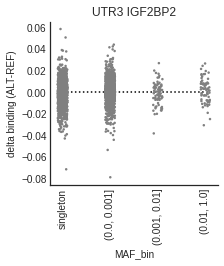

In [39]:
f, ax = plt.subplots(figsize = (3,3))

sns.stripplot(data = variants.loc[(variants['feature_type_top']=='UTR3')],
              x = 'MAF_bin', y = 'delta_score', ax = ax, marker = '.', color = 'grey')
plt.xticks(rotation=90)
plt.hlines(xmin = 0, xmax = 3,y=0, linestyles = 'dotted', color = 'black')
# x = np.arange(1,5)
# y = results.loc[results['feature_type_top']=='SS3_ADJ', 'coef'].values[0]*x
# plt.plot(x,y)
sns.despine()
plt.ylabel('delta binding (ALT-REF)')
plt.title(f'{region} {rbp}')
plt.savefig(f'{region}.{rbp}.score.pdf')

In [40]:
results = []
for name, group in variants.groupby(by = ['gene_name']):
    group['MAF_bin_rank'] = group['MAF_bin'].cat.codes
#     group.boxplot(by = 'MAF_bin', column = 'delta_score')
#     plt.title(name)
    mod = sm.OLS(group['delta_score'], group['MAF_bin_rank'])

    res = mod.fit()
    
    results.append([res.pvalues['MAF_bin_rank'], res.params['MAF_bin_rank'], name])
results = pd.DataFrame(results, columns = ['pvalue', 'coef', 'gene_name'])
_,results['FDR'] = fdrcorrection(results['pvalue'])

In [41]:
results.loc[results['FDR']<0.2].sort_values(by = 'coef')

,pvalue,coef,gene_name,FDR
41,0.015571,-0.003101,RANBP1,0.170554
52,0.016354,0.001612,SREBF2,0.170554
47,0.012160,0.004036,SGSM3,0.170554
12,0.014226,0.004946,DDX17,0.170554
70,0.007617,0.006146,ZDHHC8,0.170554
21,0.006349,0.008736,GRAP2,0.170554
22,0.013065,0.021430,GTPBP1,0.170554
